# NEURAL NETWORKS

## Part I: Building a Neural Network

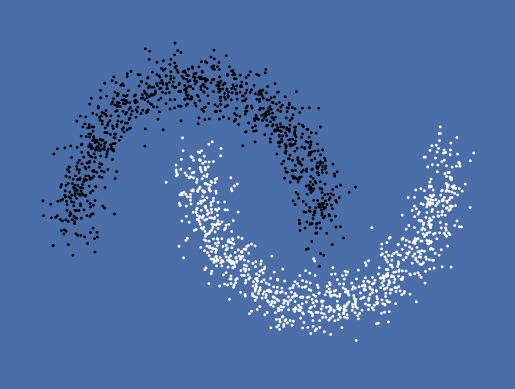

In [359]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

from sklearn.datasets import make_moons, make_circles
X, Y = make_moons(n_samples=2000, noise=0.1)
%matplotlib inline
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()

## 1. Activation Functions

In [324]:
class ReLU(object):
    def forward(self, x):
        self.x = x
        return np.maximum(x,0)  

    def backward(self):
        return (self.x > 0) * 1 
    
    def step(self, learning_rate):
        pass

class Sigmoid(object):
    def forward(self, x):
        self.x = x
        return 1./(1 + np.exp(-x))
    
    def backward(self):
        a = np.exp(-self.x)
        return a / ((a + 1) ** 2)

    def step(self, learning_rate):
        pass   

$$L(y, \hat{y}) = -[y \log(\hat{y}) + (1 - y) \log(1 - \hat{y})]$$

$$X_{i-1} -----> neuron(W,B) -----> z -----> f(z) ----->X_{i} $$
$$W \cdot X_{i-1} + B = z$$
$$f(z) = X_{i}$$
$$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial z} \times \frac{\partial z}{\partial W} $$
$$\frac{\partial L}{\partial z} = \frac{\partial L}{\partial X_{i}} \times \frac{\partial X_{i}}{\partial z} $$
$$\frac{\partial L}{\partial X_{i-1}} = \frac{\partial L}{\partial z} \times \frac{\partial z}{\partial X_{i-1}} $$

$\frac{\partial L}{\partial X_{i}}$ is propagated from next layer

$\frac{\partial z}{\partial W} = X_{i-1}$

$\frac{\partial X_{i}}{\partial z} = f'(z)$

$\frac{\partial z}{\partial X_{i-1}} = W$



$$z_{i-1}----->f(z_{i-1}) ----->X_{i-1} -----> neuron(W,B) -----> z_{i}$$
$$W \cdot X_{i-1} + B = z_{i}$$
$$f(z_{i-1}) = X_{i-1}$$
$$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial z_{i}} \times \frac{\partial z_{i}}{\partial W} $$
$$\frac{\partial L}{\partial z_{i-1}} = \frac{\partial L}{\partial X_{i-1}} \times \frac{\partial X_{i-1}}{\partial z_{i-1}} $$
$$\frac{\partial L}{\partial X_{i-1}} = \frac{\partial L}{\partial z} \times \frac{\partial z}{\partial X_{i-1}} $$
$\frac{\partial L}{\partial z_{i}}$ is propagated from next layer

$\frac{\partial z}{\partial W} = X_{i-1}$

$\frac{\partial X_{i-1}}{\partial z_{i-1}} = f'(z_{i-1})$

$\frac{\partial z}{\partial X_{i-1}} = W$


## 2. Layers

In [325]:
class Layer(object):
    def __init__(self, n_input, n_output):
        self.W = np.random.randn(n_output, n_input) # n_input = X, n_output = number of neurons 
        self.B = np.zeros(n_output).reshape(-1,1)

    def forward(self, X_input):
        self.X = X_input
        z = self.W @ self.X + self.B
        
        return z

    def backward(self, dz):
        self.dW = dz @ self.X.transpose()
        self.dB = np.sum(dz, axis=1, keepdims=True)
        self.dX = self.W.transpose() @ dz

        return self.dX
        
    
    def step(self, learning_rate):
        self.W = self.W - learning_rate * self.dW
        self.B = self.B - learning_rate * self.dB


In [326]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))
# plot the decision boundary of our classifier
def plot_decision_boundary(ax, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting
  
    Z = classifier.forward(to_forward.transpose())
    Z = Z.reshape(xx.shape)
    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z>0.5, cmap='Blues')
    
    # then plot the dataset
    plot_data(ax, X,Y)

## 3. BCE Loss Function
- For each example in the training set, the model predicts a probability value between 0 and 1.
The BCE loss function then calculates the difference between the predicted probability and the actual label (which is either 0 or 1).
The BCE loss function then takes the average of these differences across all examples in the training set.
$$L(y, \hat{y}) = -[y \log(\hat{y}) + (1 - y) \log(1 - \hat{y})]$$
where y is actual label (either 0 or 1), ŷ is the predicted probability value (between 0 and 1), and log is the natural logarithm.

- The BCE loss function is minimized when the predicted probability values are close to the actual labels. A perfect model would have a BCE loss of 0.



In [327]:
class NeuralNetwork(object):

    def __init__(self, n_inputs: int, n_neurons: int, n_hidden_layers: int):
        self.layers = []

        self.layers.append(Layer(n_inputs, n_neurons))
        self.layers.append(ReLU())

        for i in range(n_hidden_layers):
            self.layers.append(Layer(n_neurons, n_neurons))
            self.layers.append(ReLU())

        self.layers.append(Layer(n_neurons, 1))
        self.layers.append(Sigmoid())

        self.predict = None
        self.gradient = None

    def forward(self, _input):
        X = _input
        for layer in self.layers:
            X = layer.forward(X)
        self.predict = X
        return X
    
    def compute_loss(self, out, label):
        e = 1e-10
        loss = -(label * np.log(out + e) + (1 - label) * np.log(1 - out + e))
        self.gradient = (out - label) / (((1 - out) * out) + e)
        
        return loss

    def backward(self):
        prev = self.gradient
        print("prev: ", prev)
        for i in range(len(self.layers)-1, -1, -2):
            prev = prev * self.layers[i].backward()
            print("prev: ", prev)
            prev = self.layers[i-1].backward(prev)
            print("prev: ", prev)
            
    
    def step(self, learning_rate):
        for layer in self.layers:
            layer.step(learning_rate)

## 4. Test Our Network


In [360]:
network = NeuralNetwork(n_inputs = len(X[0].ravel()), n_hidden_layers = 4, n_neurons = 8)
losses = []
learning_rate = 1e-3
epochs = 10
for epoch in range(epochs):
    loss = 0
    for iteration in range(len(X)):
        i = np.random.randint(0,len(X))
        predicted = network.forward(X[i].reshape(-1,1))
        l = network.compute_loss(predicted, Y[i])
        loss += l[0][0]
        network.backward()
        network.step(learning_rate)
    losses.append(loss)




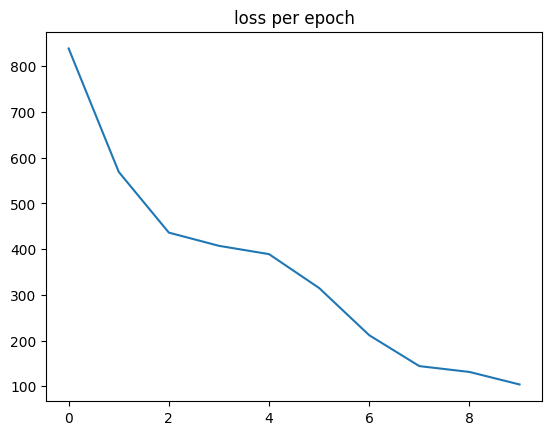

In [329]:
%matplotlib inline
plt.plot(losses)
plt.title("loss per epoch")
plt.show()

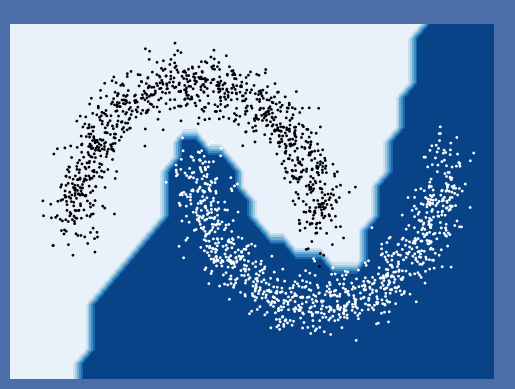

In [361]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, network)
fig.canvas.draw()

## 5. a Harder test

according to noise, seprating two circles are more difficult, so we need more neurons.

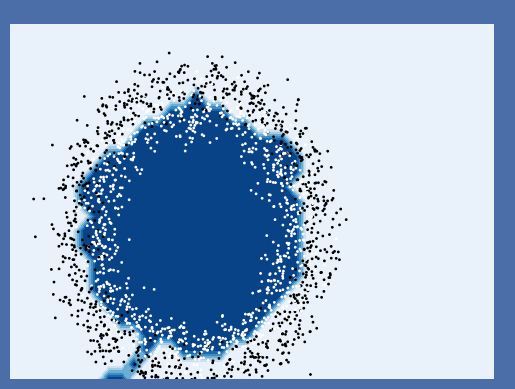

In [364]:
X, Y = make_circles(n_samples=2000, noise=0.1)

network = NeuralNetwork(n_inputs = len(X[0].ravel()), n_hidden_layers = 4, n_neurons = 10)
losses = []
learning_rate = 1e-3
epochs = 10
for epoch in range(epochs):
    loss = 0
    for iteration in range(len(X)):
        i = np.random.randint(0,len(X))
        predicted = network.forward(X[i].reshape(-1,1))
        l = network.compute_loss(predicted, Y[i])
        loss += l[0][0]
        network.backward()
        network.step(learning_rate)
    losses.append(loss)

fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, network)
fig.canvas.draw()


## Part II: Making a Neural Netwrok by Using PyTorch 



## 1. Load & Preprocess 

In [332]:
import pandas as pd
data = pd.read_csv("imdb_dataset.csv")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [333]:
data.isna().sum()

review       0
sentiment    0
dtype: int64

## 1.1 Normalize Text

## 1.1.1 Stemming and lemmatization
- `Stemming` and lemmatization are two techniques used in natural language processing to reduce words to their base or root form. These techniques are often used to improve the accuracy of text analysis and information retrieval systems, such as search engines and chatbots.
Stemming is the process of reducing words to their stem or base form by removing the suffixes. For example, the stem of the word "run_modelning" is "run_model", and the stem of the word "jogging" is "jog". Stemming is a simple and fast technique, but it can sometimes produce incorrect or non-words, as it does not consider the context of the word.

- `Lemmatization` is a more sophisticated technique that involves reducing words to their base form using linguistic rules and morphological analysis. Unlike stemming, lemmatization takes into account the context of the word and ensures that the resulting base form is a valid word. For example, the lemma of the word "run_model_modelning" is also "run_model", but the lemma of the word "jogging" is "jog", which is a valid word.

## 1.1.2 Stop Word:
- In natural language processing, stop words are words that are commonly used in a language but are often considered to be of little value in text analysis and information retrieval tasks. These words are typically short, common words that do not carry much meaning on their own, such as "the", "and", "of", "is", and "in".

- Stop words are often removed from text data before analysis or indexing, as they can increase processing time and memory usage without adding much value to the results. By removing stop words, the remaining words in the text can better represent the important concepts and themes, and the resulting analysis or search results can be more relevant and precise.

- It's also important to note that stop words removal is not always necessary or appropriate for every application. In some cases, stop words may carry important information and meaning, especially in applications that involve sentiment analysis, topic modeling, or social media analysis. Therefore, it's important to carefully consider the trade-offs between accuracy and efficiency when deciding whether to remove stop words or not, and to evaluate the performance of the text analysis system in the specific context of the application.

## 1.1.3 punctuation
we need to remove all punctuations, because it does not provide any useful informations.

## 1.1.4 HTML 
we need to remove all symbols using in HTML.

In [334]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import regex
import string
from copy import deepcopy
from bs4 import BeautifulSoup

def normalize_text(text):
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    text = text.translate(str.maketrans('', '', string.punctuation))
    stemmer = PorterStemmer()
    text = stemmer.stem(text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(filtered_tokens)
    return text


In [335]:
data['review'] = data['review'].apply(normalize_text)

C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  if sys.path[0] == "":


## 1.2. Label Encoding 

In [336]:
from sklearn.preprocessing import LabelEncoder

data['sentiment'] = LabelEncoder().fit_transform(data['sentiment'])

## 1.3. Train & Test split


In [337]:
RATIO = 0.2

from sklearn.model_selection import train_test_split
splitted = train_test_split(data['review'], data['sentiment'], test_size = RATIO, random_state=1)
X_train, X_test, y_train, y_test = splitted


## 1.4 Vectorize Text


`TD-IDF` Method:

- `TF` part of TF-IDF measures the frequency of a term in a document. It is calculated by dividing the number of times a term appears in a document by the total number of terms in the document. This helps to identify the most frequently occurring words in a document.

- `IDF` part of TF-IDF measures the specificity of a term across the entire corpus. It is calculated by dividing the total number of documents in the corpus by the number of documents that contain the term. This helps to identify the words that are unique to a particular document and not commonly used across the corpus.
According to fact that we may have so many features, we only keep most-repeated ones by limiting our featurs


## 1.5 Normalize Inputs of Network
- When the input data is not normalized, the weights of the neural network can become very large or very small, which can lead to numerical instability during training. Normalizing the input data to a range of 0 to 1 can help to prevent this problem.

- In addition, normalizing the input data can help to ensure that all features are treated equally by the neural network. If the input features have different scales, some features may dominate the others, leading to biased results. Normalizing the input data can help to prevent this problem and ensure that all features are treated equally.

- `TD-IDF` method also normalize the vector.


In [338]:
MAX_FEATURES = 3000

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = MAX_FEATURES)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)



## 1.6. Tensorize
we need to transform our data to tensor data type, because we are going to use `PyTorch` methods.

In [339]:
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader
X_train = torch.tensor(X_train.todense())
y_train = torch.tensor(y_train.values)

X_test = torch.tensor(X_test.todense())
y_test = torch.tensor(y_test.values)

PyTorch only accepts float:

In [340]:
X_train = X_train.float()
X_test = X_test.float()

In [341]:
data_train = TensorDataset(X_train, y_train)
data_test = TensorDataset(X_test, y_test)

X_test = data_test.tensors[0]
y_test = data_test.tensors[1]

X_train = data_train.tensors[0]
y_train = data_train.tensors[1]

## 1.7 Batch
we need batch training because: 

- `Efficiency`: Batch training can be more efficient than online training, where the weights are updated after each training example. By processing multiple training examples at once, batch training can take advantage of parallel processing and reduce the amount of time required for data transfer.

- `Stability`: Batch training can lead to more stable training, as the gradient estimates are more accurate and less noisy. This can help to prevent the model from getting stuck in local minima and improve the convergence of the training process.
- `Memory`: Batch training can help to reduce the memory requirements of the neural network, as the weights are updated less frequently. This can be important for large neural networks or when working with limited memory resources.
- `Generalization`: Batch training can help to improve the generalization performance of the neural network, as the model is exposed to more diverse examples during training. This can help to prevent overfitting and improve the model's ability to generalize to new data.

In [342]:
def load_data(_batch_size = 50):
    return DataLoader(data_train, batch_size = _batch_size)

## 2. Neural Network
now it is the time to make our network

## 2.1 Define Layers and Network

In [343]:
import torch.nn.init as init
import math

class MyLinear_mod(nn.Module):
    def __init__(self, n_input, n_output, distribution):
        super(MyLinear_mod, self).__init__()
        self.W = nn.Parameter(torch.empty(n_output, n_input))
        self.B = nn.Parameter(torch.empty(n_output).view(-1,1))
        distribution(self.W)
        distribution(self.B)
        
    def forward(self, X_input):
        self.X = X_input
        z = torch.matmul(self.W, self.X) + self.B
        
        return z
        
class MyReLU_mod(nn.Module):
    def __init__(self):
        super(MyReLU_mod, self).__init__()
        
    def forward(self, x):
        return torch.max(torch.tensor(0), x)


- The `Tanh` and `Sigmoid` functions in hidden layers can suffer from the vanishing gradient problem, especially when the input values are very large or very small.

- in binary classification activation function of last layer should be `Sigmoid` becuse we need our output to be between 0 and 1.

In [344]:
def make_network(n_inputs, n_neurons, n_hidden_layers, activation_function, distribution):
    layers = []

    layers.append(MyLinear_mod(n_inputs, n_neurons, distribution))
    layers.append(activation_function)
    for i in range(n_hidden_layers):
        layers.append(MyLinear_mod(n_neurons, n_neurons, distribution))
        layers.append(activation_function)
    layers.append(MyLinear_mod(n_neurons, 1, distribution))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

## 2.2 ReLU vs LeakyReLU
- `ReLU` (Rectified Linear Unit) and `LeakyReLU` are both activation functions used in neural networks. The main difference between them is how they handle negative input values.
- `ReLU` sets all negative input values to zero, while `LeakyReLU` sets negative input values to a small non-zero value, typically 0.01 times the input value. This small non-zero value is called the "leak".
The mathematical expressions for ReLU and Leaky ReLU are as follows:

$$ReLU: f(x) = max(0, x)$$
$$Leaky ReLU: f(x) = max(0.01 \times x, x)$$

- The advantage of using `LeakyReLU` over `ReLU` is that it can help to prevent the "dying ReLU" problem, where neurons with negative input values are stuck at zero and do not contribute to the output of the network. By allowing a small non-zero output for negative input values, Leaky ReLU can help to keep these neurons active and prevent them from "dying".
- However, in some cases, `ReLU` may be more effective than `LeakyReLU`, especially when the input values are always positive. `ReLU` is also simpler and faster to compute than `LeakyReLU`.

In [345]:
from torch import optim
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

def run_model(n_neurons = 50, n_hidden_layers = 2, activation_function = nn.LeakyReLU(), distribution = init.xavier_uniform_, 
        learning_rate = 0.1, epochs = 10, batch_size = 50, print_res = False):

    network = make_network(n_inputs = MAX_FEATURES, n_neurons = n_neurons, n_hidden_layers = n_hidden_layers,
                            activation_function = activation_function, distribution = distribution)
    
    dataloader = load_data(batch_size)

    optimizer = optim.SGD(network.parameters(), lr = learning_rate)

    losses = []
    accuracies = []
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        loss_value = 0
        for X, Y in dataloader:

            res = network.forward(X.T)
            loss = criterion(res.view(-1), Y.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_value += loss.item()
        
        losses.append(loss_value)

        with torch.no_grad():
            train_res = network.forward(X_train.T).view(-1)
            y_pred_train = (train_res > 0.5).float()
            y_pred_train = y_pred_train.detach().numpy()

            test_res = network.forward(X_test.T).view(-1)
            y_pred_test = (test_res > 0.5).float()
            y_pred_test = y_pred_test.detach().numpy()

            acc_test = accuracy_score(y_test, y_pred_test)
            accuracies.append(round(100 *acc_test, 3))

            if(print_res):
                print(f"***** epoch {epoch + 1} *****")
                print("train: ")

                
                print(f"accuray =", "{0:.2%}".format(accuracy_score(y_train, y_pred_train)))
                print(f"precision =", "{0:.2%}".format(precision_score(y_train, y_pred_train)))
                print(f"recall =", "{0:.2%}".format(recall_score(y_train, y_pred_train)))
                print(f"f1 =", "{0:.2%}".format(f1_score(y_train, y_pred_train)))

                print(*(['-'] * 50), sep='')
                print("test: ")
                
                print(f"accuray =", "{0:.2%}".format(acc_test))
                print(f"precision =", "{0:.2%}".format(precision_score(y_test, y_pred_test)))
                print(f"recall =", "{0:.2%}".format(recall_score(y_test, y_pred_test)))
                print(f"f1 test ", "{0:.2%}".format(f1_score(y_test, y_pred_test)))

                matrix = confusion_matrix(y_test, y_pred_test)
                display_matrix = ConfusionMatrixDisplay(matrix)
                display_matrix.plot(cmap = 'Blues')
                plt.title('Test Data Confusion Matrix')
                plt.show()


                print(*(['*'] * 70), sep='')

    return losses, accuracies




## 2.2 Weight and Bias initializing

- `uniform_`: Initializes the weights with values drawn from a uniform distribution. The function takes a tensor as input and initializes its values with random numbers drawn from a uniform distribution.

- `normal_`: Initializes the weights with values drawn from a normal distribution. The function takes a tensor as input and initializes its values with random numbers drawn from a normal distribution.
- `constant_`: Initializes the weights with a constant value. The function takes a tensor as input and initializes all its values with the same constant value.
- `eye_`: Initializes the weights with an identity matrix. The function takes a tensor as input and initializes it with an identity matrix.
dirac_: Initializes the weights with a Dirac delta function. The function takes a tensor as input and initializes it with a Dirac delta function.
- `xavier_uniform_`: Initializes the weights with values drawn from a uniform distribution, scaled by the square root of the number of input units. This is also known as the Xavier initialization.
- `xavier_normal_`: Initializes the weights with values drawn from a normal distribution, scaled by the square root of the number of input units. This is also known as the Xavier initialization.
- `kaiming_uniform_`: Initializes the weights with values drawn from a uniform distribution, scaled by the square root of 2 over the number of input units. This is also known as the He initialization.
- `kaiming_normal_`: Initializes the weights with values drawn from a normal distribution, scaled by the square root of 2 over the number of input units. This is also known as the He initialization.

## 3. Test and Analyze


***** epoch 1 *****
train: 
accuray = 50.11%
precision = 50.11%
recall = 100.00%
f1 = 66.76%
--------------------------------------------------
test: 
accuray = 49.56%
precision = 49.56%
recall = 100.00%
f1 test  66.27%


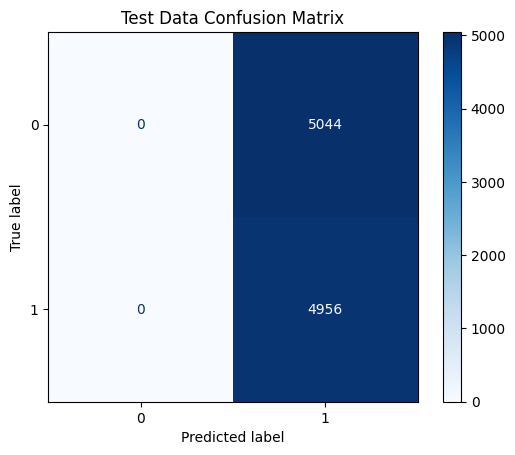

**********************************************************************
***** epoch 2 *****
train: 
accuray = 50.40%
precision = 50.26%
recall = 100.00%
f1 = 66.89%
--------------------------------------------------
test: 
accuray = 49.83%
precision = 49.69%
recall = 100.00%
f1 test  66.39%


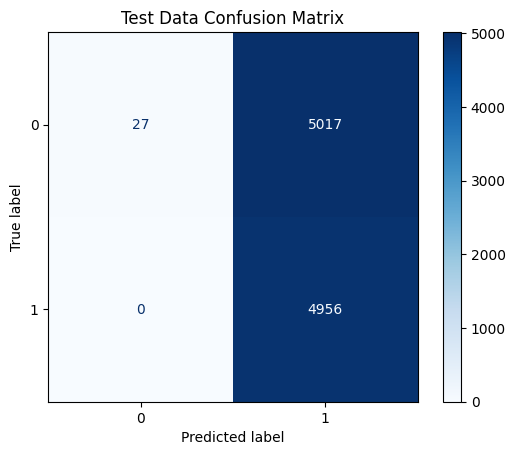

**********************************************************************
***** epoch 3 *****
train: 
accuray = 76.83%
precision = 95.66%
recall = 56.32%
f1 = 70.90%
--------------------------------------------------
test: 
accuray = 76.43%
precision = 95.45%
recall = 55.06%
f1 test  69.84%


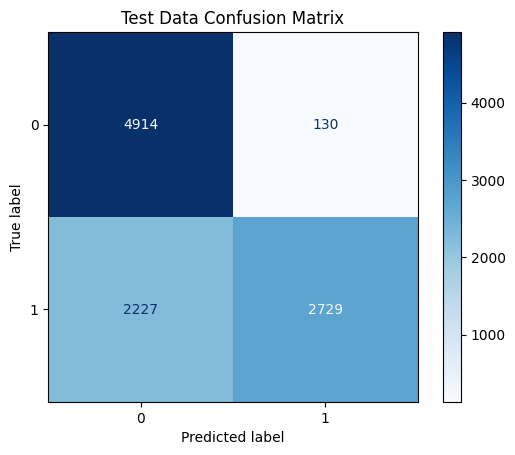

**********************************************************************
***** epoch 4 *****
train: 
accuray = 85.67%
precision = 93.30%
recall = 76.93%
f1 = 84.33%
--------------------------------------------------
test: 
accuray = 84.95%
precision = 92.53%
recall = 75.75%
f1 test  83.30%


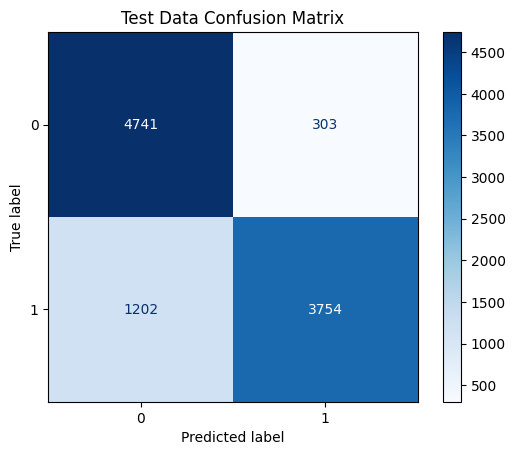

**********************************************************************
***** epoch 5 *****
train: 
accuray = 88.94%
precision = 87.73%
recall = 90.60%
f1 = 89.14%
--------------------------------------------------
test: 
accuray = 87.71%
precision = 86.09%
recall = 89.69%
f1 test  87.85%


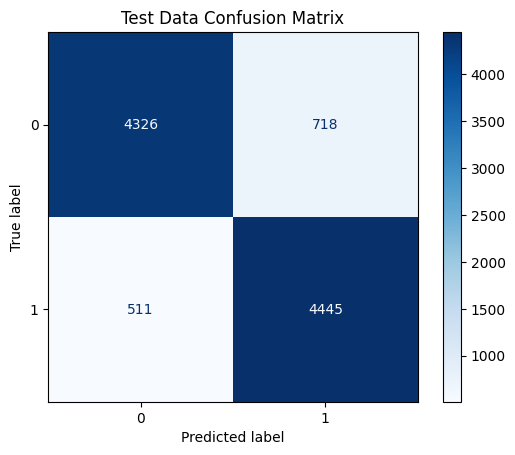

**********************************************************************
***** epoch 6 *****
train: 
accuray = 87.34%
precision = 94.36%
recall = 79.50%
f1 = 86.29%
--------------------------------------------------
test: 
accuray = 85.98%
precision = 92.76%
recall = 77.78%
f1 test  84.61%


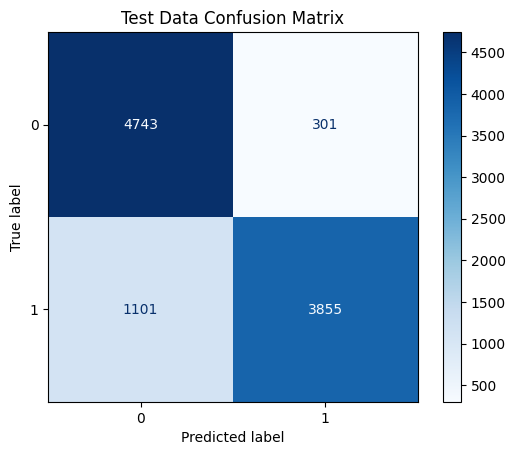

**********************************************************************
***** epoch 7 *****
train: 
accuray = 88.98%
precision = 93.12%
recall = 84.23%
f1 = 88.45%
--------------------------------------------------
test: 
accuray = 87.57%
precision = 91.54%
recall = 82.55%
f1 test  86.81%


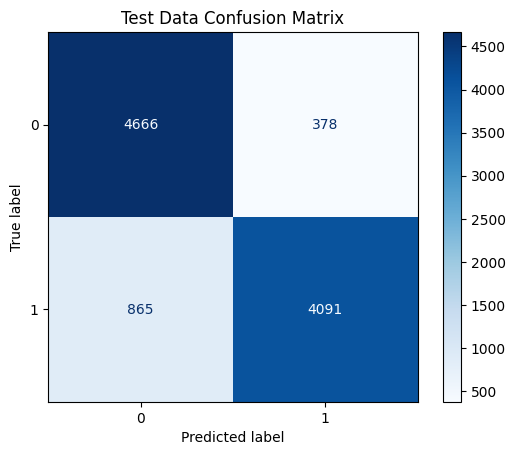

**********************************************************************
***** epoch 8 *****
train: 
accuray = 89.53%
precision = 92.98%
recall = 85.57%
f1 = 89.12%
--------------------------------------------------
test: 
accuray = 87.79%
precision = 91.11%
recall = 83.51%
f1 test  87.15%


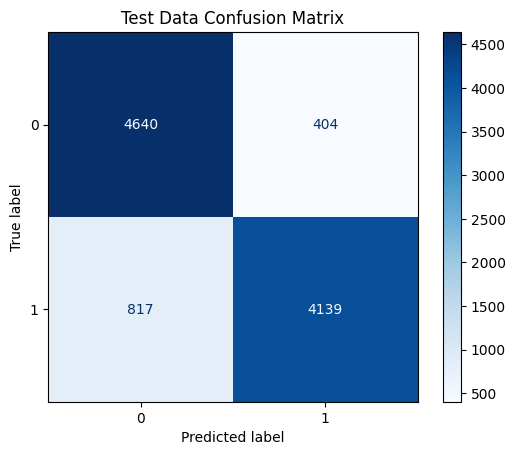

**********************************************************************
***** epoch 9 *****
train: 
accuray = 86.91%
precision = 95.78%
recall = 77.27%
f1 = 85.54%
--------------------------------------------------
test: 
accuray = 85.37%
precision = 93.96%
recall = 75.32%
f1 test  83.62%


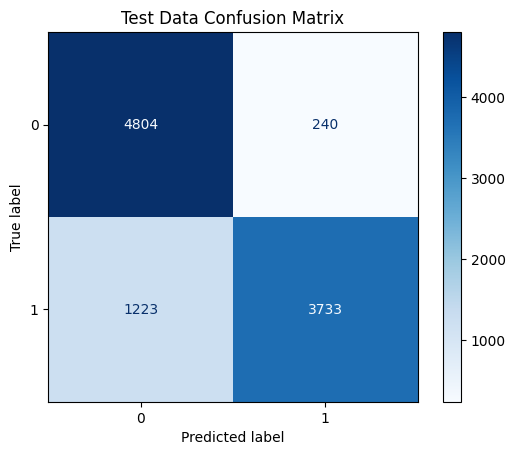

**********************************************************************
***** epoch 10 *****
train: 
accuray = 90.37%
precision = 92.09%
recall = 88.37%
f1 = 90.19%
--------------------------------------------------
test: 
accuray = 87.99%
precision = 89.35%
recall = 86.02%
f1 test  87.65%


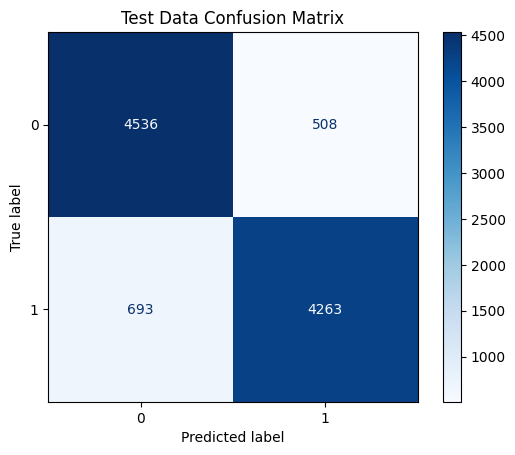

**********************************************************************


In [356]:
losses, accuracies = run_model(
    n_neurons = 150,
    n_hidden_layers = 5,
    activation_function = MyReLU_mod(),
    distribution = init.xavier_uniform_,
    learning_rate = 0.1,
    epochs = 10,
    batch_size = 100,
    print_res = True
)

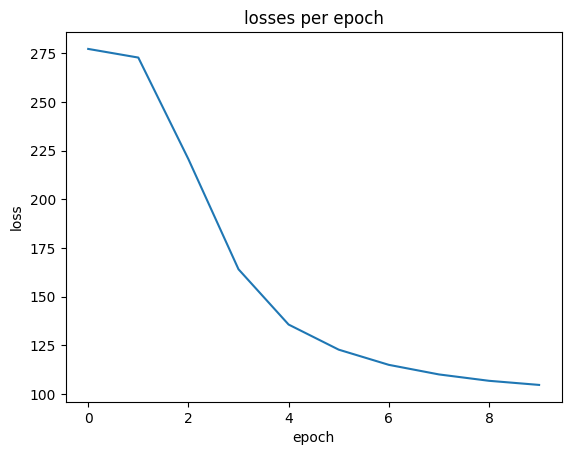

In [357]:
plt.plot(losses)
plt.title('losses per epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

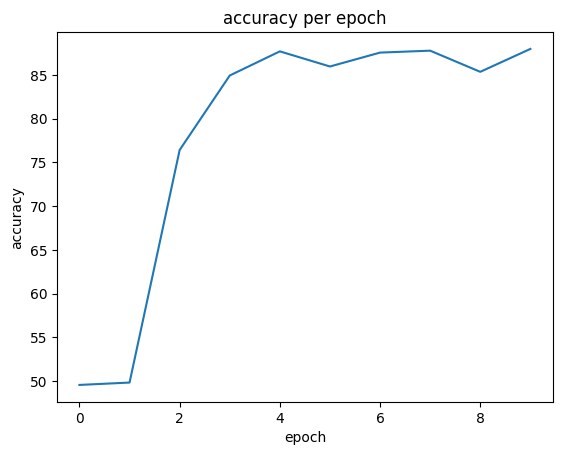

In [358]:
plt.plot(accuracies)
plt.title('accuracy per epoch')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## 3.1 Learning Rate

- `Convergence speed`: A higher learning rate can lead to faster convergence during training, as the model takes larger steps towards the optimal solution. However, a learning rate that is too high can cause the model to overshoot the optimal solution and diverge.

- `Stability`: A lower learning rate can lead to more stable training, as the model takes smaller steps towards the optimal solution. This can help to prevent the model from overshooting the optimal solution and improve the convergence of the training process.
- `Generalization`: A lower learning rate can lead to better generalization performance, as the model is exposed to more diverse examples during training. This can help to prevent overfitting and improve the model's ability to generalize to new data.
- `Accuracy`: The optimal learning rate for a neural network depends on the specific problem and architecture. In some cases, a higher learning rate may lead to better accuracy, while in other cases a lower learning rate may be more effective.

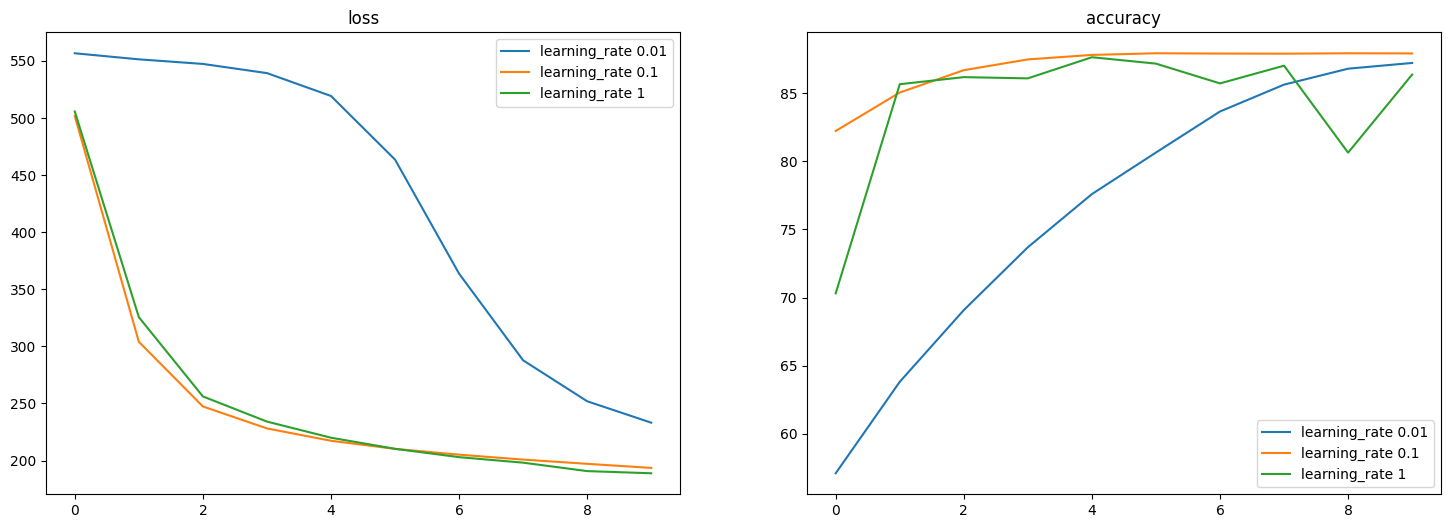

,epoch 1,epoch 2,epoch 3,epoch 4,epoch 5,epoch 6,epoch 7,epoch 8,epoch 9,epoch 10
learning_rate 0.01,57.11,63.82,69.08,73.69,77.59,80.64,83.65,85.62,86.79,87.21
learning_rate 0.1,82.22,85.04,86.68,87.47,87.80,87.92,87.90,87.89,87.92,87.91
learning_rate 1,70.31,85.65,86.17,86.08,87.63,87.16,85.71,87.01,80.63,86.36


In [348]:
EPOCHS = 10
learning_rates = [0.01, 0.1, 1]



cols = []
rows = []
for i in range(EPOCHS):
    cols.append(f'epoch {i + 1}')
for i in learning_rates:
    rows.append(f'learning_rate {i}')
    
result = pd.DataFrame(index=rows, columns=cols)

fig, axs = plt.subplots(1,2,figsize=(18,6))

for i in learning_rates:
    losses, acc = run_model(learning_rate = i, epochs = EPOCHS)
    result.loc[f'learning_rate {i}',:] = acc

    axs[0].plot(losses, label = f'learning_rate {i}')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(acc, label = f'learning_rate {i}')
    axs[1].set_title('accuracy')
    axs[1].legend()

plt.show()
result.fillna('-',inplace=True)
display(result)

## 3.2 Activation Function

- `Sigmoid`: The sigmoid function maps the input to a value between 0 and 1. It is often used in binary classification problems. However, the sigmoid function can suffer from the vanishing gradient problem, which can make training slow and difficult.

- `ReLU`: The rectified linear unit (ReLU) function maps the input to 0 if it is negative, and to the input value if it is positive. ReLU is a popular activation function due to its simplicity and effectiveness. It can help to prevent the vanishing gradient problem and improve the convergence of the training process.
- `LeakyReLU`: The leaky ReLU function is similar to ReLU, but it allows a small gradient when the input is negative. This can help to prevent the "dying ReLU" problem, where neurons can become permanently inactive during training.
- `Tanh`: The hyperbolic tangent (tanh) function maps the input to a value between -1 and 1. It is often used in recurrent neural networks (RNNs) and can help to prevent the vanishing gradient problem.

- NOTE: distribution, when the activation functions are `Sigmoid`, must be `Normal`.

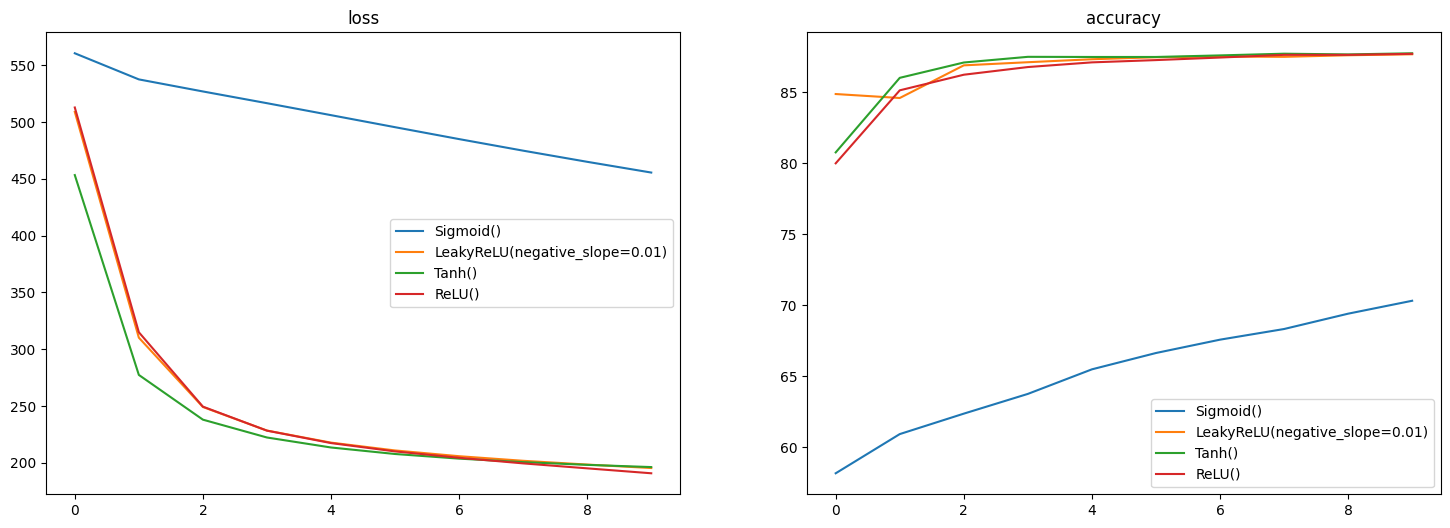

,epoch 1,epoch 2,epoch 3,epoch 4,epoch 5,epoch 6,epoch 7,epoch 8,epoch 9,epoch 10
Sigmoid(),58.18,60.94,62.38,63.77,65.50,66.65,67.59,68.34,69.42,70.33
LeakyReLU(negative_slope=0.01),84.89,84.61,86.91,87.13,87.34,87.48,87.53,87.51,87.62,87.69
Tanh(),80.78,86.03,87.11,87.51,87.50,87.50,87.61,87.73,87.68,87.76
ReLU(),80.01,85.15,86.25,86.79,87.12,87.28,87.46,87.65,87.65,87.72


In [349]:
EPOCHS = 10
activation_function = [nn.Sigmoid(), nn.LeakyReLU(), nn.Tanh(), nn.ReLU()]



cols = []
rows = []
for i in range(EPOCHS):
    cols.append(f'epoch {i + 1}')
for i in activation_function:
    rows.append(f'{i}')
    
result = pd.DataFrame(index=rows, columns=cols)

fig, axs = plt.subplots(1,2,figsize=(18,6))

for i in activation_function:
    if(f'{i}' == 'Sigmoid()'):
        losses, acc = run_model(activation_function = i, epochs = EPOCHS, distribution = init.normal_)
    else:
        losses, acc = run_model(activation_function = i, epochs = EPOCHS)

    result.loc[f'{i}',:] = acc

    axs[0].plot(losses, label = f'{i}')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(acc, label = f'{i}')
    axs[1].set_title('accuracy')
    axs[1].legend()

plt.show()
result.fillna('-',inplace=True)
display(result)

## 3.3 Batch Size

- `Training` time: A larger batch size can lead to faster training times, as the model can process more samples in each iteration. However, larger batch sizes may require more memory and computational resources.

- `Generalization`: A smaller batch size can lead to better generalization performance, as the model is exposed to more diverse examples in each iteration. This can help to prevent overfitting and improve the model's ability to generalize to new data.
- `Stability`: A larger batch size can lead to more stable training, as the gradient estimates are more accurate and less noisy. This can help to prevent the model from getting stuck in local minima and improve the convergence of the training process.
- `Accuracy`: The optimal batch size for a neural network depends on the specific problem and architecture. In some cases, a larger batch size may lead to better accuracy, while in other cases a smaller batch size may be more effective.

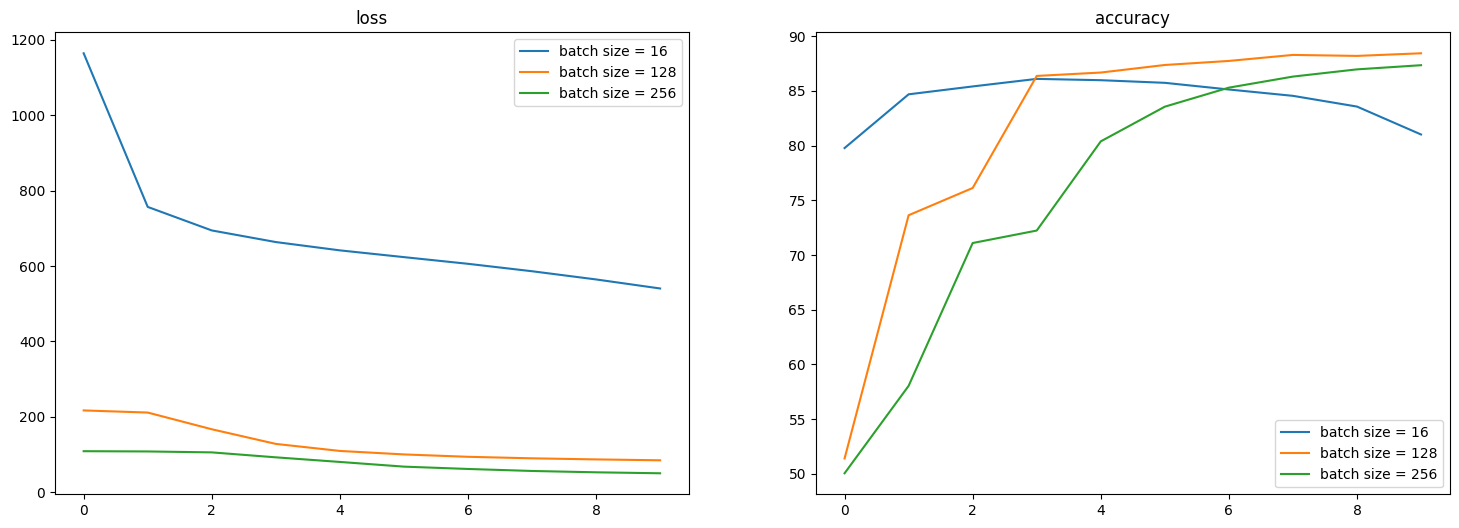

,epoch 1,epoch 2,epoch 3,epoch 4,epoch 5,epoch 6,epoch 7,epoch 8,epoch 9,epoch 10
batch size = 16,79.77,84.68,85.40,86.09,85.97,85.73,85.12,84.54,83.56,81.01
batch size = 128,51.40,73.63,76.12,86.36,86.67,87.36,87.73,88.28,88.19,88.43
batch size = 256,50.05,58.04,71.09,72.23,80.38,83.55,85.29,86.30,86.96,87.34


In [350]:
EPOCHS = 10
batch_sizes = [16,128,256]



cols = []
rows = []
for i in range(EPOCHS):
    cols.append(f'epoch {i + 1}')
for i in batch_sizes:
    rows.append(f'batch size = {i}')
    
result = pd.DataFrame(index=rows, columns=cols)

fig, axs = plt.subplots(1,2,figsize=(18,6))

for i in batch_sizes:

    losses, acc = run_model(batch_size = i, epochs = EPOCHS)

    result.loc[f'batch size = {i}',:] = acc

    axs[0].plot(losses, label = f'batch size = {i}')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(acc, label = f'batch size = {i}')
    axs[1].set_title('accuracy')
    axs[1].legend()

plt.show()
result.fillna('-',inplace=True)
display(result)